# Lorentzian fit to find Signal to Noise

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
from scipy import optimize

#To introduce a range of 3D plots, we need to import another library
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# The following line makes the images a bit larger than default - works better on a large screen
plt.rcParams['figure.figsize'] = 10,10

import astropy
from astropy.io import fits
import os

import  H_alpha as ha

## Loading images 

In [52]:
# fits file in the same folder with python notebook
home_dir = os.getcwd()+'/'
print ("The Home Directory is set to:", home_dir) # check the home directory

The Home Directory is set to: /Users/kiradavidoff/code/astrophysics/PROJECT_HALPHA/


In [53]:

Dark_files, Dark_images, Dark_names = ha.dark()
Bias_files, Bias_images, Bias_names= ha.bias()
Light_file, Light_images, Light_names= ha.lights()

## Remove readout and bias from light 

In [54]:
Bias1 = Bias_images[1]
Bias2 = Bias_images[2]

diffB = Bias2 - Bias1
dB = np.diff(Bias_images)

RDnoise = np.std(dB) / np.sqrt(100.0)

print(f"the read out noise is {RDnoise}")

the read out noise is 3274.4552163441467


the exposure time for Stars and Dark frame are the same

In [55]:
# subtract the mean bias from all frames
Dark_images_bs = Dark_images - np.mean(Bias_images, axis=0)

# substract the Dark frame from the Light images with bias subtracted
Light_images_correct = Light_images - np.mean(Dark_images_bs, axis=0)- np.mean(Bias_images, axis=0)


len(Light_images_correct)

15

In [56]:
# Dark uncertainty
sigma_dark = np.sqrt(np.mean(Dark_images_bs, axis=0)) / np.sqrt(np.abs(len(Dark_images_bs)))
sigma_Bias = np.std(Bias_images,axis=0) / np.sqrt(len(Bias_images))
sigma_signal= np.sqrt(np.abs(Light_images_correct[0]))
sigma_dark_cor= np.sqrt(sigma_dark**2+sigma_Bias**2)
noise= np.sqrt(sigma_dark_cor**2+sigma_Bias**2+sigma_signal**2)


/var/folders/rm/q9sj039x3qqgdn5jb6y2c8k00000gn/T/ipykernel_85838/3710709146.py:2: RuntimeWarning: invalid value encountered in sqrt
  sigma_dark = np.sqrt(np.mean(Dark_images_bs, axis=0)) / np.sqrt(np.abs(len(Dark_images_bs)))


## Removing Background on the H_alpha line

<div class="alert alert-success"> 
 <b>Plot Image to see where H_alpha is at</b>

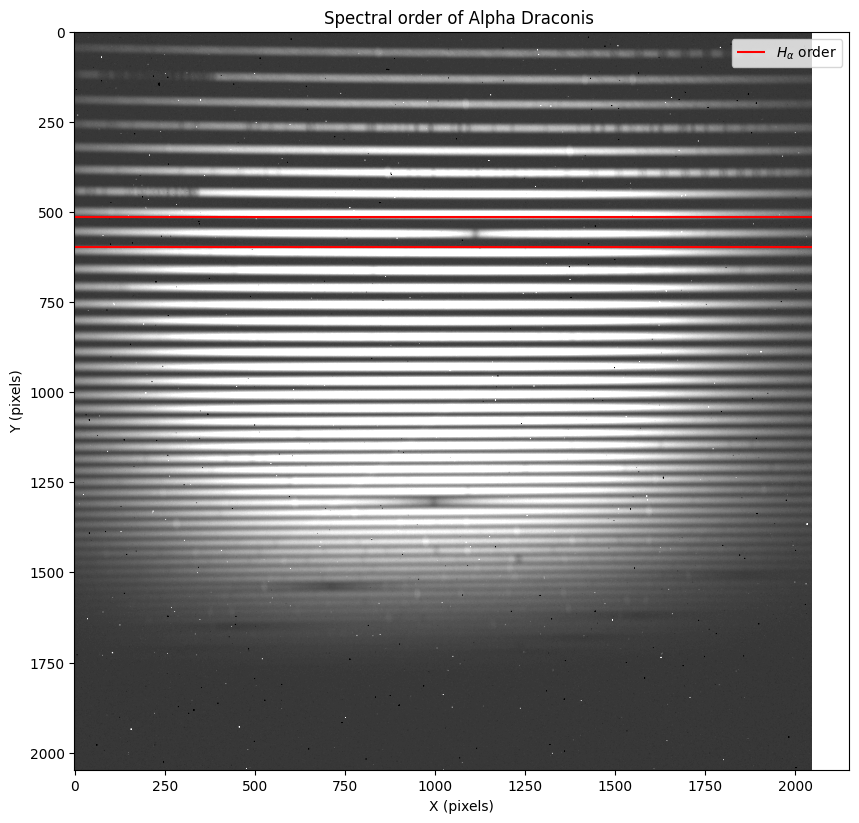

In [57]:

ha.quickplot(Light_images_correct[0], Light_names[0])

plt.hlines(513,0,2048,'r', label= r'$H_\alpha$ order')
plt.hlines(596,0 ,2048, 'r')
plt.title("Spectral order of Alpha Draconis ")
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.legend()

<div class="alert alert-success"> 

 **Create a subset around H_alpha**

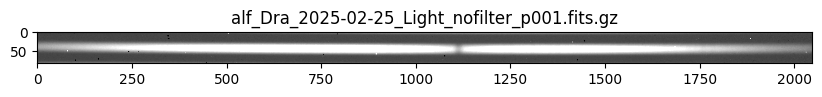

In [58]:


ha.quickplot(Light_images_correct[0][513:596,0:2048], Light_names[0])


<div class="alert alert-success">

 **Find by observation where the background is at:**

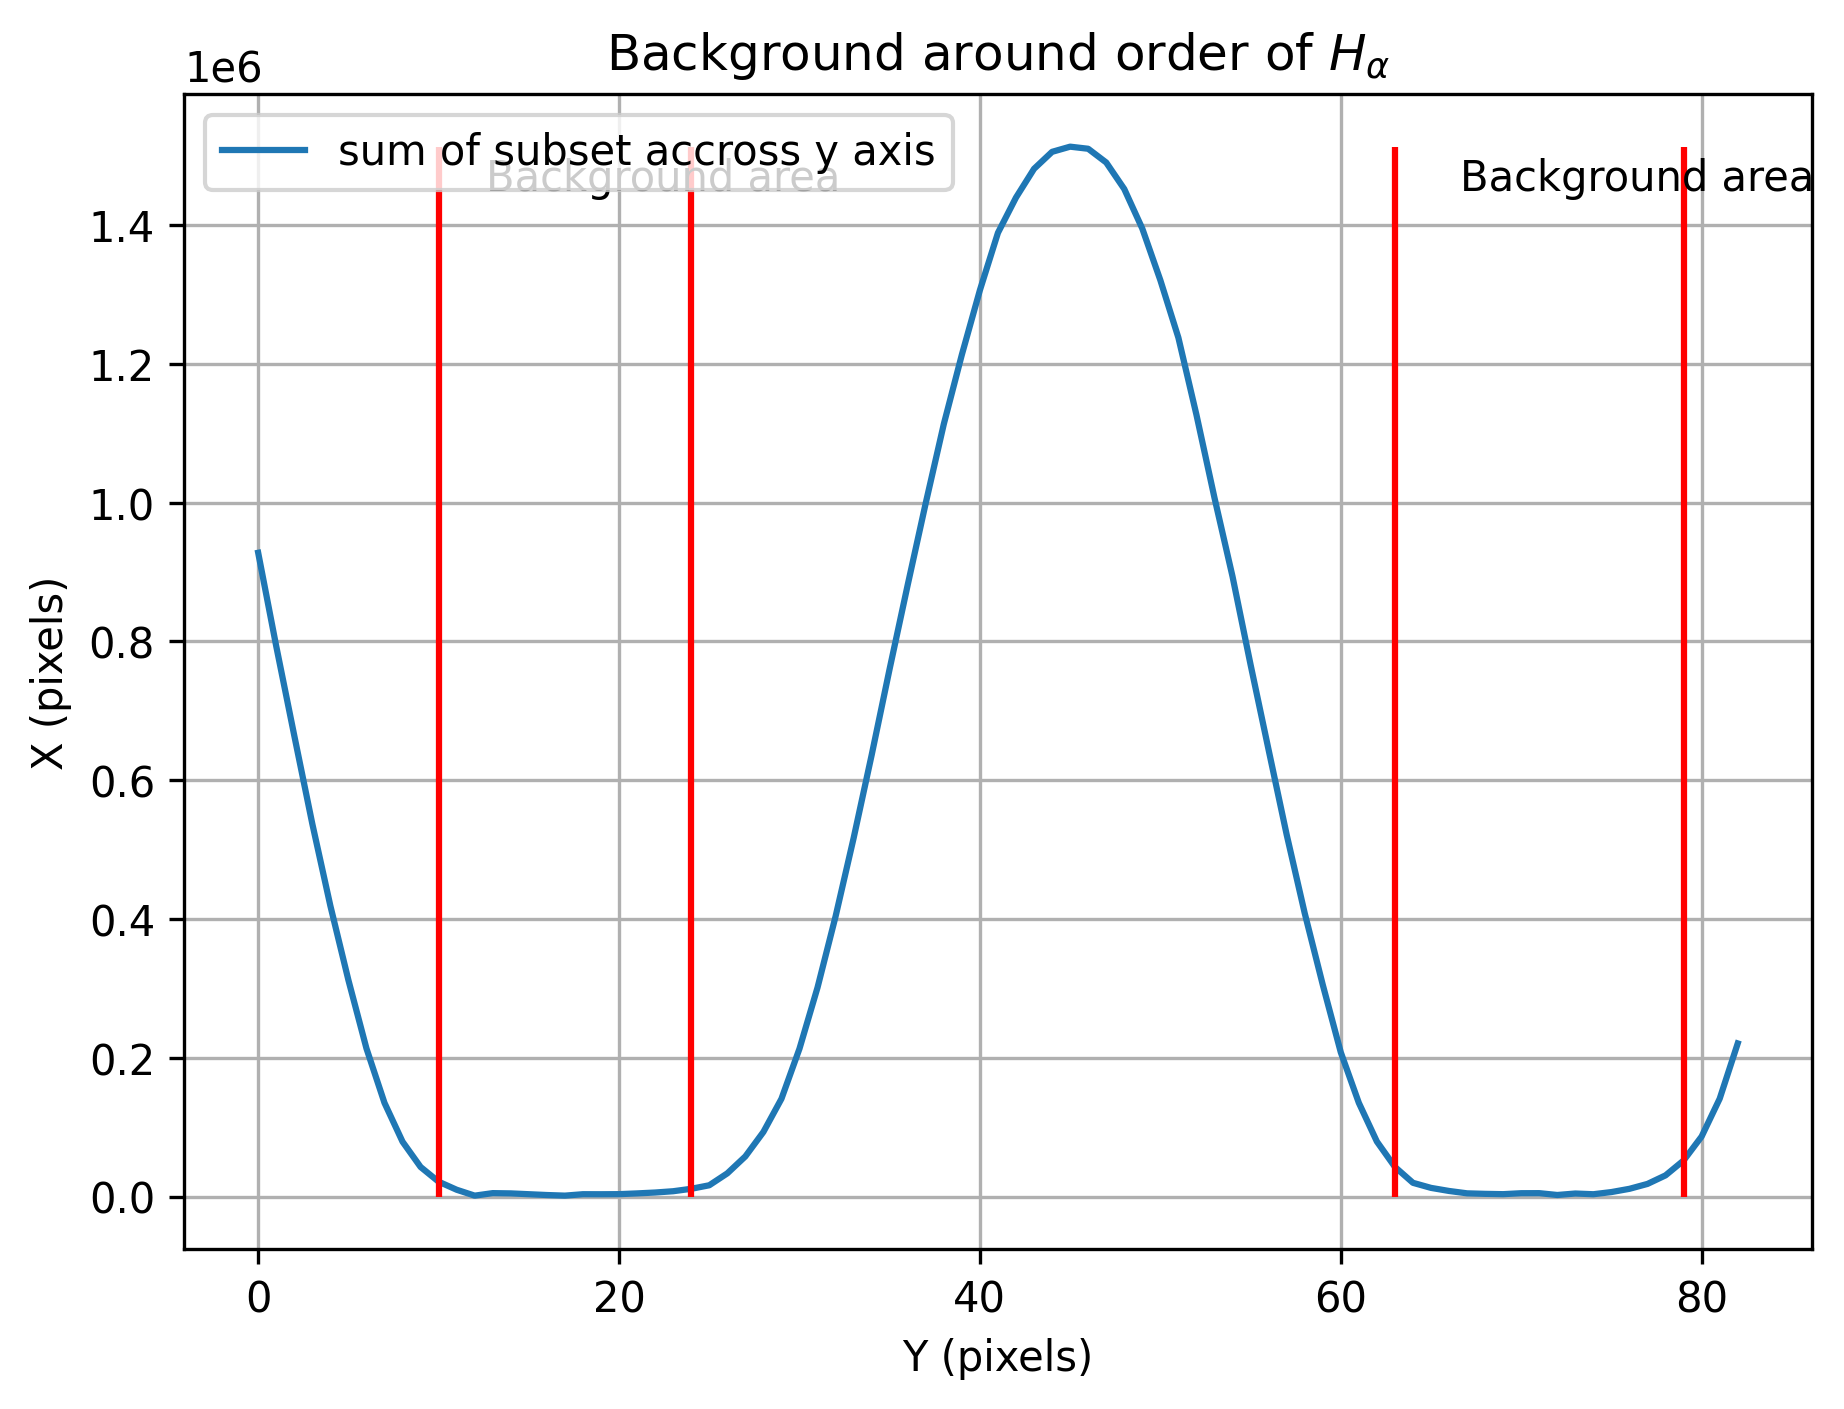

In [59]:
plt.figure(figsize=(7,5),dpi=300)



plt.plot(np.sum(Light_images_correct[0][513:596,0:2048],axis=1),label='sum of subset accross y axis')
plt.grid()
plt.vlines(10, 0, np.max(np.sum(Light_images_correct[0][513:596,0:2048],axis=1))+2, 'red')
plt.vlines(24, 0, np.max(np.sum(Light_images_correct[0][513:596,0:2048],axis=1))+2, 'red')
plt.vlines(63, 0, np.max(np.sum(Light_images_correct[0][513:596,0:2048],axis=1))+2, 'red')
plt.vlines(79, 0, np.max(np.sum(Light_images_correct[0][513:596,0:2048],axis=1))+2, 'red')
plt.text(12.6,1.45e6,'Background area')
plt.text(66.6,1.45e6,'Background area')
plt.title(r'Background around order of $H_\alpha$')
plt.xlabel('Y (pixels)')
plt.ylabel('X (pixels)')
plt.legend()

<div class="alert alert-success">

  **Input the background range**
 
 Initial subset  = 513:596

 Background range 1 = 10:24 \
 Background range 2 = 62:79

 New subset = 513+10 : 513+79

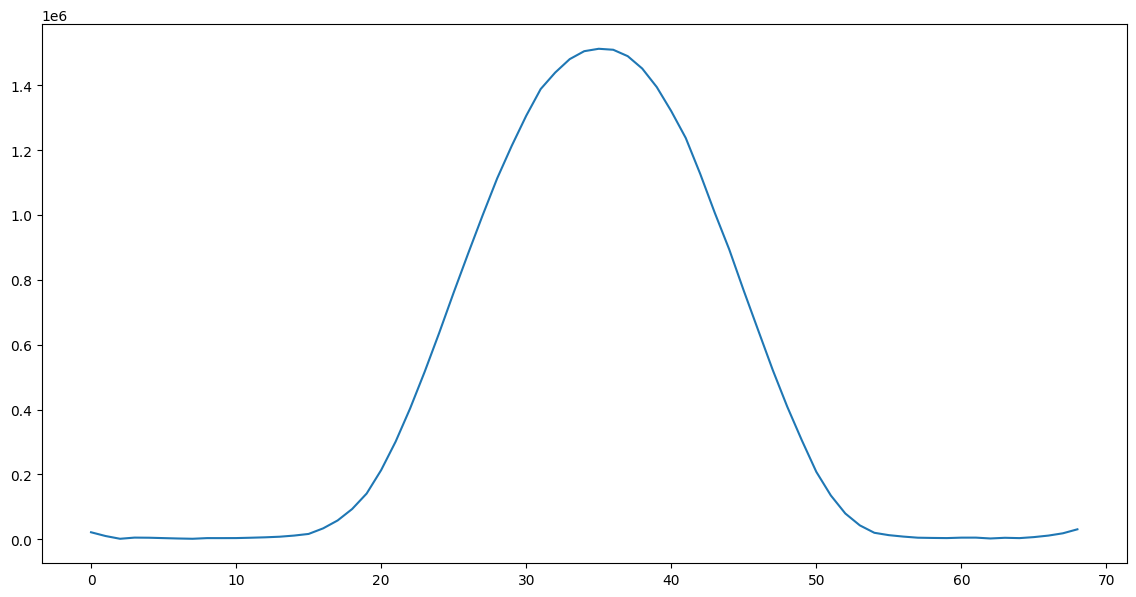

In [60]:
plt.figure(figsize=(14,7))
plt.plot(np.sum(Light_images_correct[0][523:592,0:2048],axis=1))

In [61]:
# Guetting the background
background_1= np.mean(Light_images_correct[1][513:596,0:2048][10:24])
background_2= np.mean(Light_images_correct[1][513:596,0:2048][63:77])

sigma_b1= noise[513:596,0:2048][10:24]
sigma_b2= noise[513:596,0:2048][63:77]

sigmab = np.concatenate([sigma_b1, sigma_b2], axis=0)

alf_Dra_p001_02= Light_images_correct[1][520:590,0:2048] - (background_1+ background_2)/2



propagated_error =np.sqrt( np.mean(sigmab)**2 + noise[520:590,0:2048]**2)
noise_sqrt=np.sqrt(np.sum(propagated_error**2,axis=0))/np.sqrt(2048)


In [62]:
alf_Dra_p001_02_1D= np.sum(alf_Dra_p001_02, axis=0)

In [63]:
noise_final =noise_sqrt
noise_final

array([2.02228956, 2.05949658, 2.06230111, ..., 1.92614451, 1.89822807,
       1.87964053])

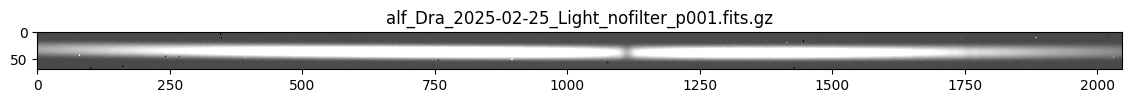

In [64]:
plt.figure(figsize=(14,7))

ha.quickplot(alf_Dra_p001_02, Light_names[0])

## H_alpha spectrum creation and normalisation

<div class="alert alert-success">

  **Collapsing the spectrum to 1D**
 
Doing sum accross x axis

Text(0, 0.5, 'Flux (sum of Y pixels)')

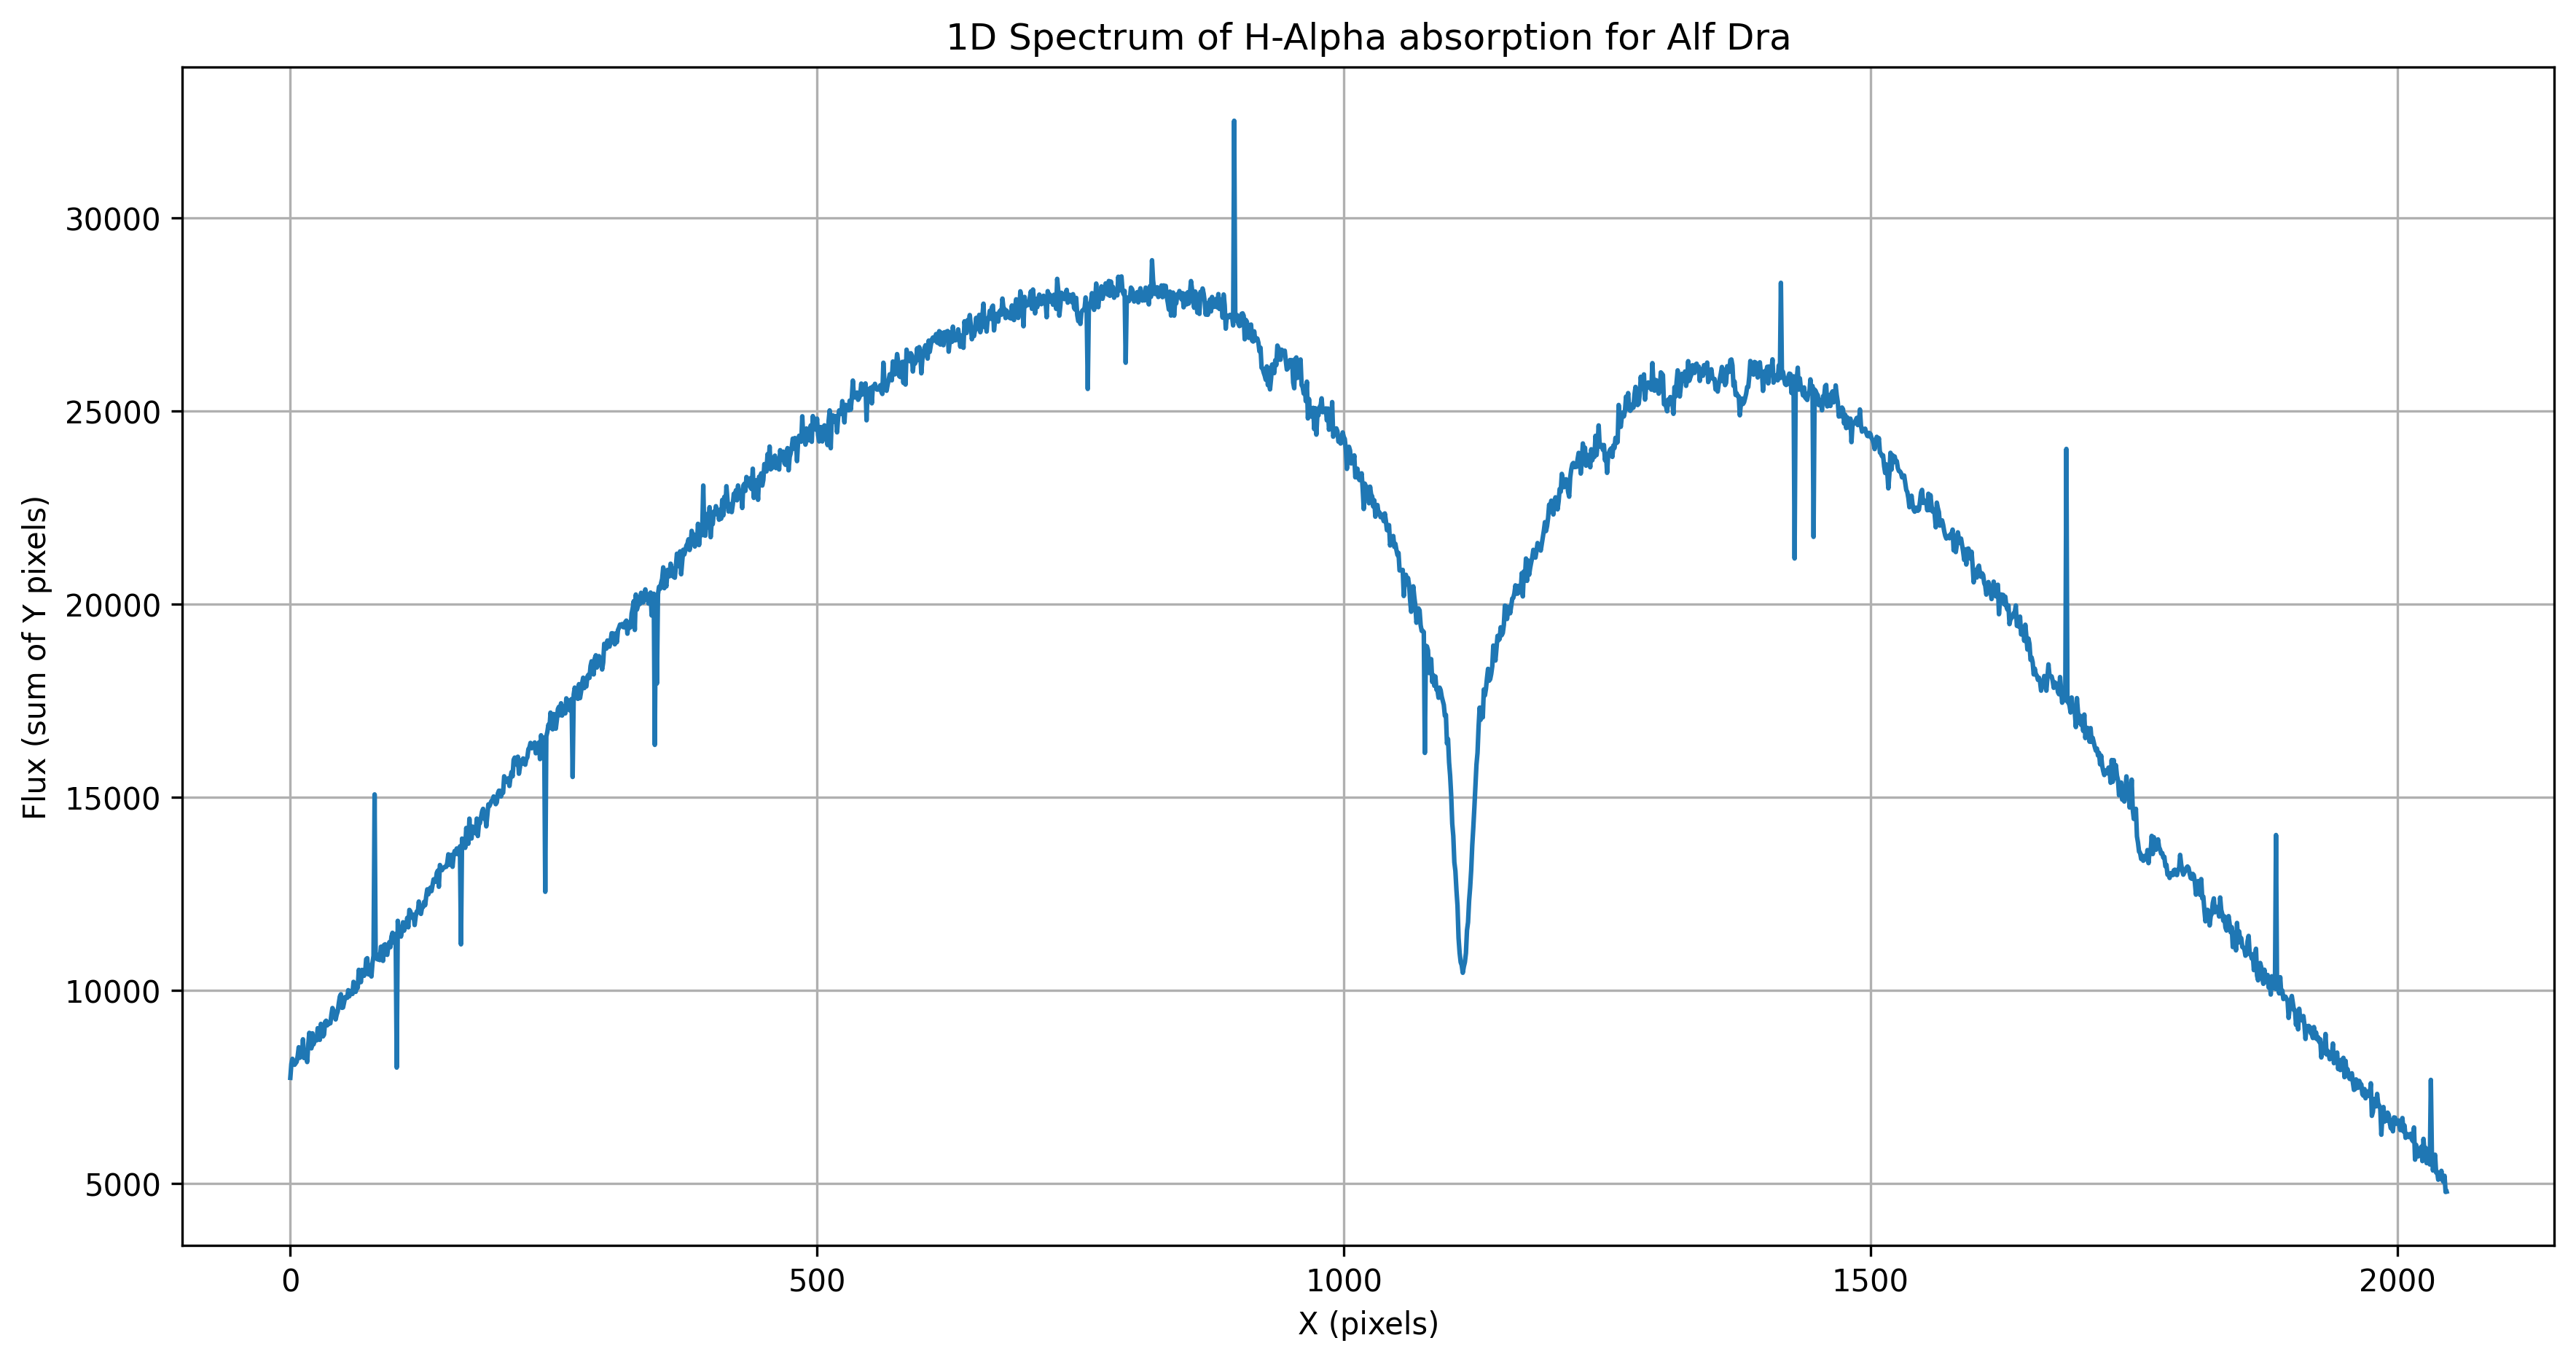

In [65]:
alf_Dra_p001_02_1D= np.sum(alf_Dra_p001_02, axis=0)

plt.figure(figsize=(14,7),dpi=300)
plt.title('1D Spectrum of H-Alpha absorption for Alf Dra')
plt.grid()
plt.plot(alf_Dra_p001_02_1D)
plt.xlabel('X (pixels)')
plt.ylabel('Flux (sum of Y pixels)')


<div class="alert alert-success">

  **Removing outliers with median filter**
 


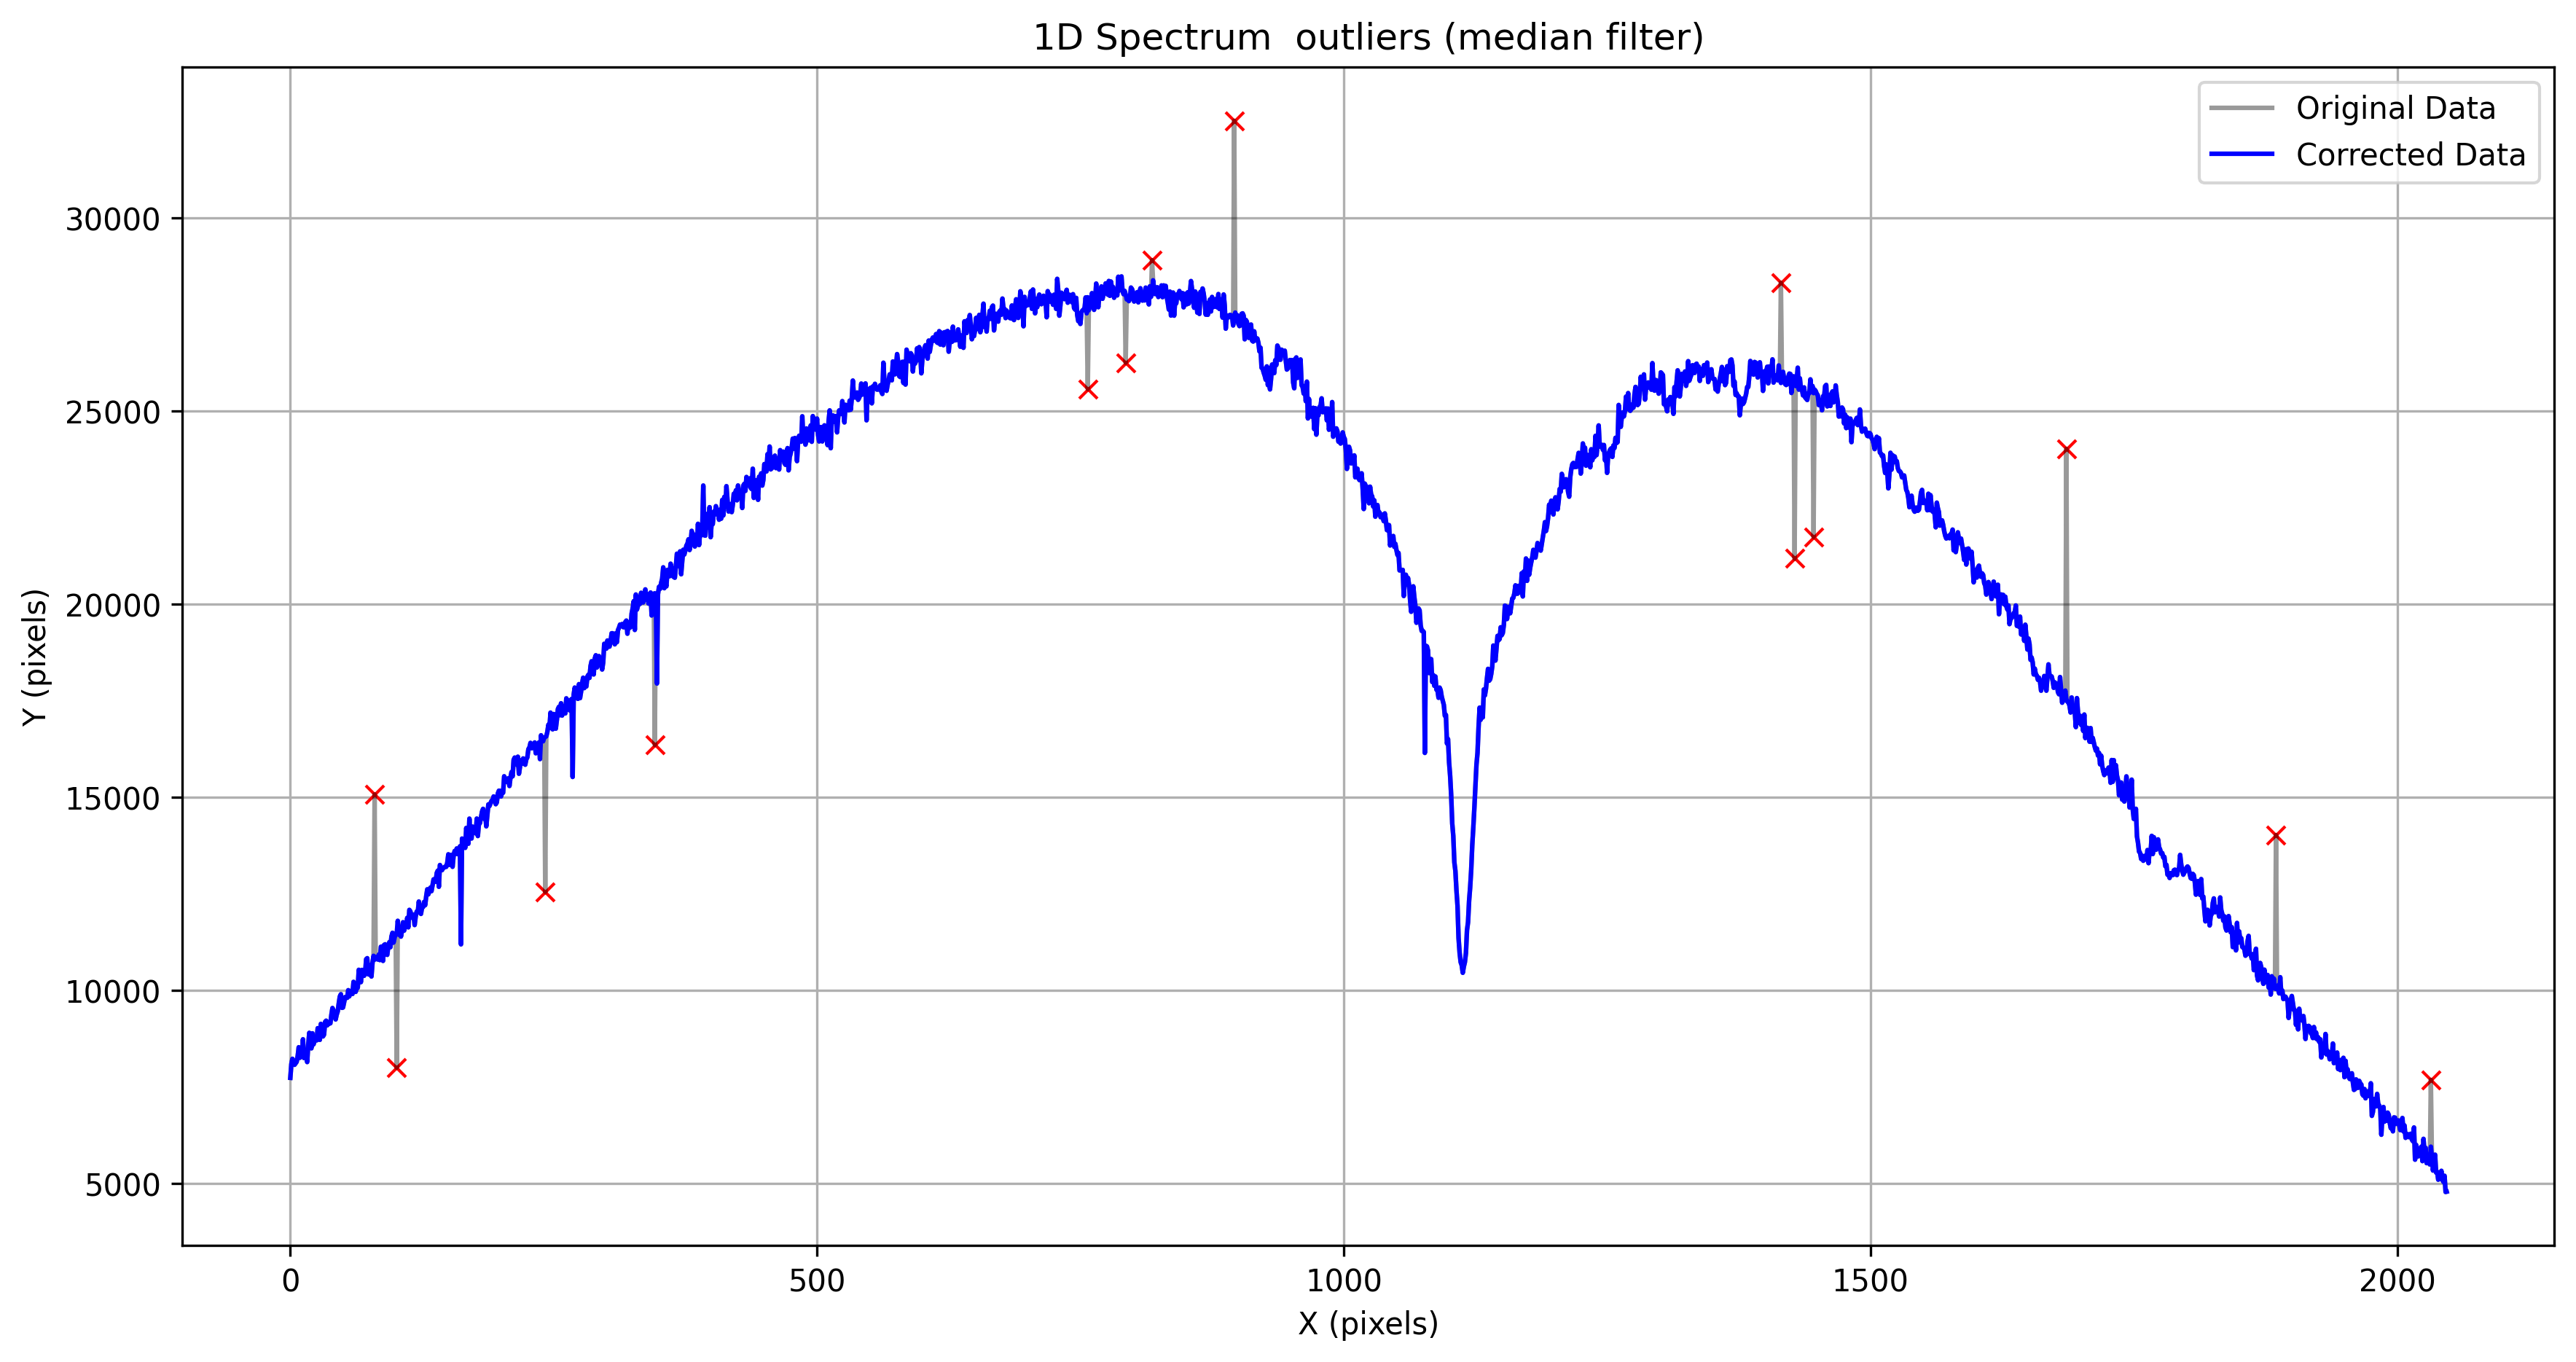

(array([7740.68713379, 8099.63713379, 8232.88713379, ..., 5204.43713379,
        4786.03713379, 4793.73713379]),
 array([2.02228956, 2.05949658, 2.06230111, ..., 1.92614451, 1.89822807,
        1.87964053]))

In [66]:
plt.figure(figsize=(14,7),dpi=300)
plt.grid()
plt.title('1D Spectrum  outliers (median filter)')
plt.grid()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
ha.outliers_replace_median_with_uncertainty(alf_Dra_p001_02_1D,noise_final, plot=True)

In [67]:
alf_Dra_p001_02_1D_corrected, noise_corrected=ha.outliers_replace_median_with_uncertainty(alf_Dra_p001_02_1D, noise_final, clip=3, windowSize=25)

[520:590,0:2048]
[520:590,0:2048]
[520:590,0:2048]

In [68]:
alf_Dra_p001_02_1D_corrected, noise_corrected=ha.MedianClipRolling(alf_Dra_p001_02_1D,noise_final,clip=3, windowSize=25)

<div class="alert alert-success">

  **Normalising the spectrum**
 

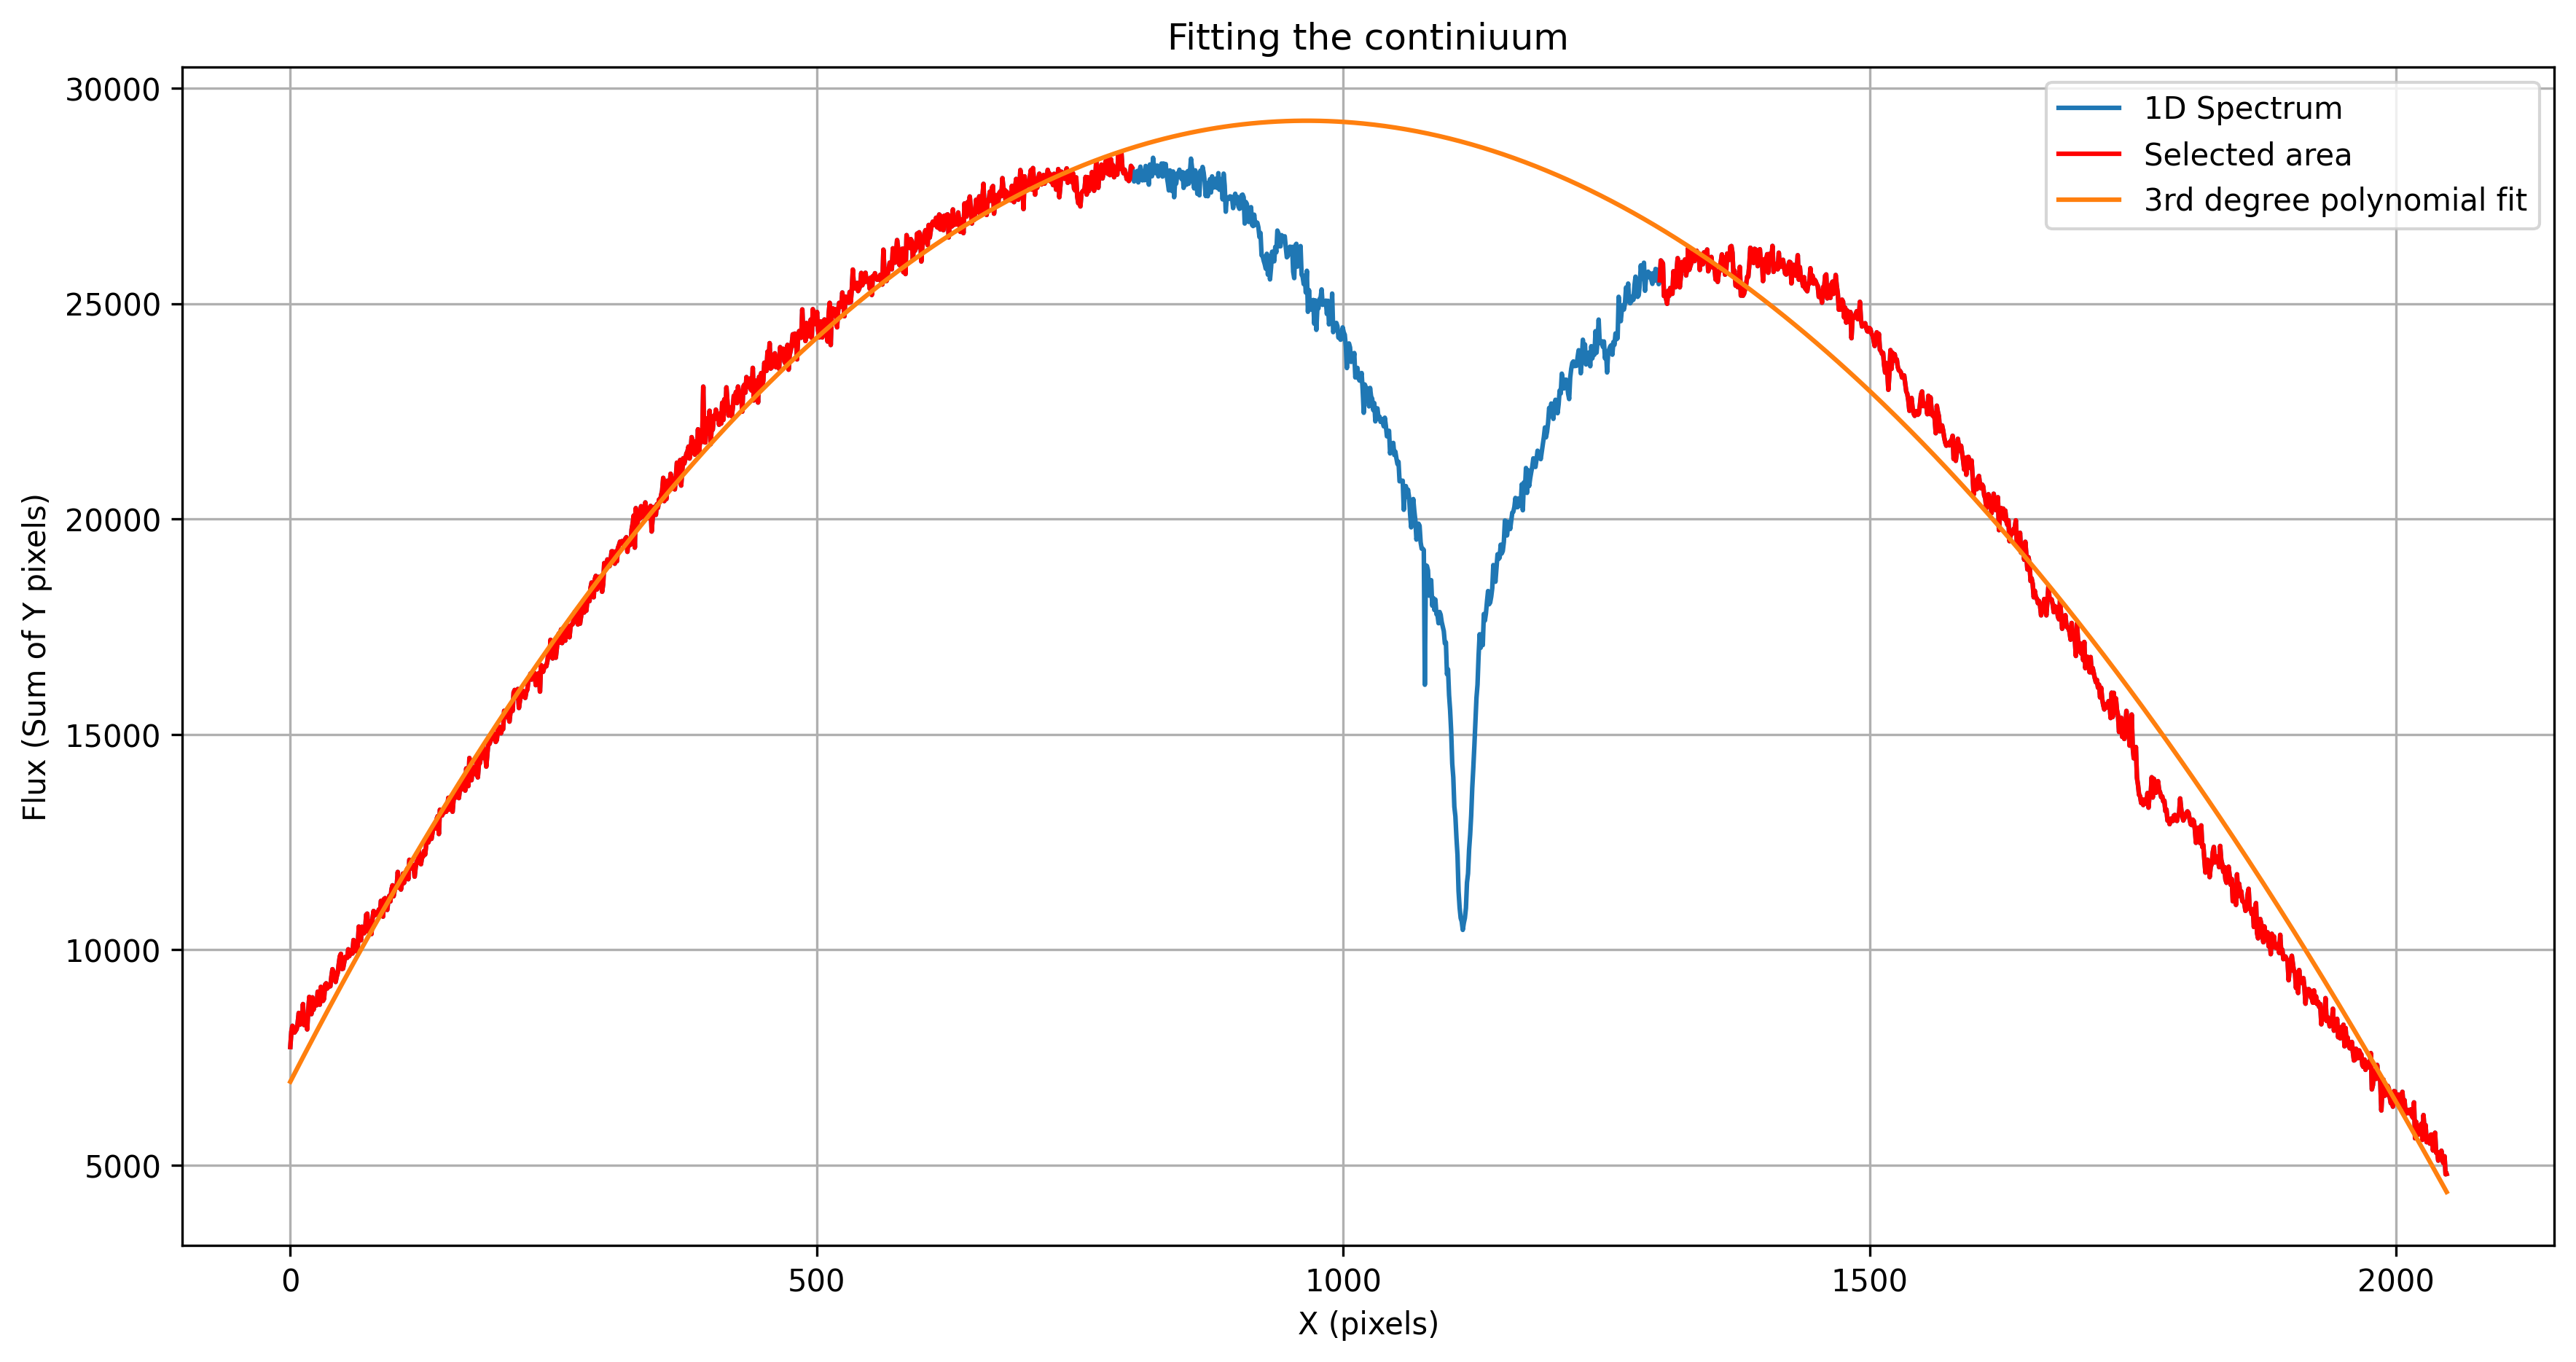

(array([1.11587453, 1.15968595, 1.17081777, ..., 1.16575847, 1.08279644,
        1.09554012]),
 array([0.00729581, 0.00753062, 0.00755191, ..., 0.39802845, 0.37380274,
        0.38243819]))

In [ ]:
plt.figure(figsize=(14,7), dpi=300)
plt.title('Fitting the continiuum')
ha.Normalise( alf_Dra_p001_02_1D_corrected,noise_corrected, 800, 1300, plot = True)


In [70]:
continium_normarlised,normalised_err= ha.Normalise( alf_Dra_p001_02_1D_corrected,noise_corrected, 700, 1300)

780, 1330

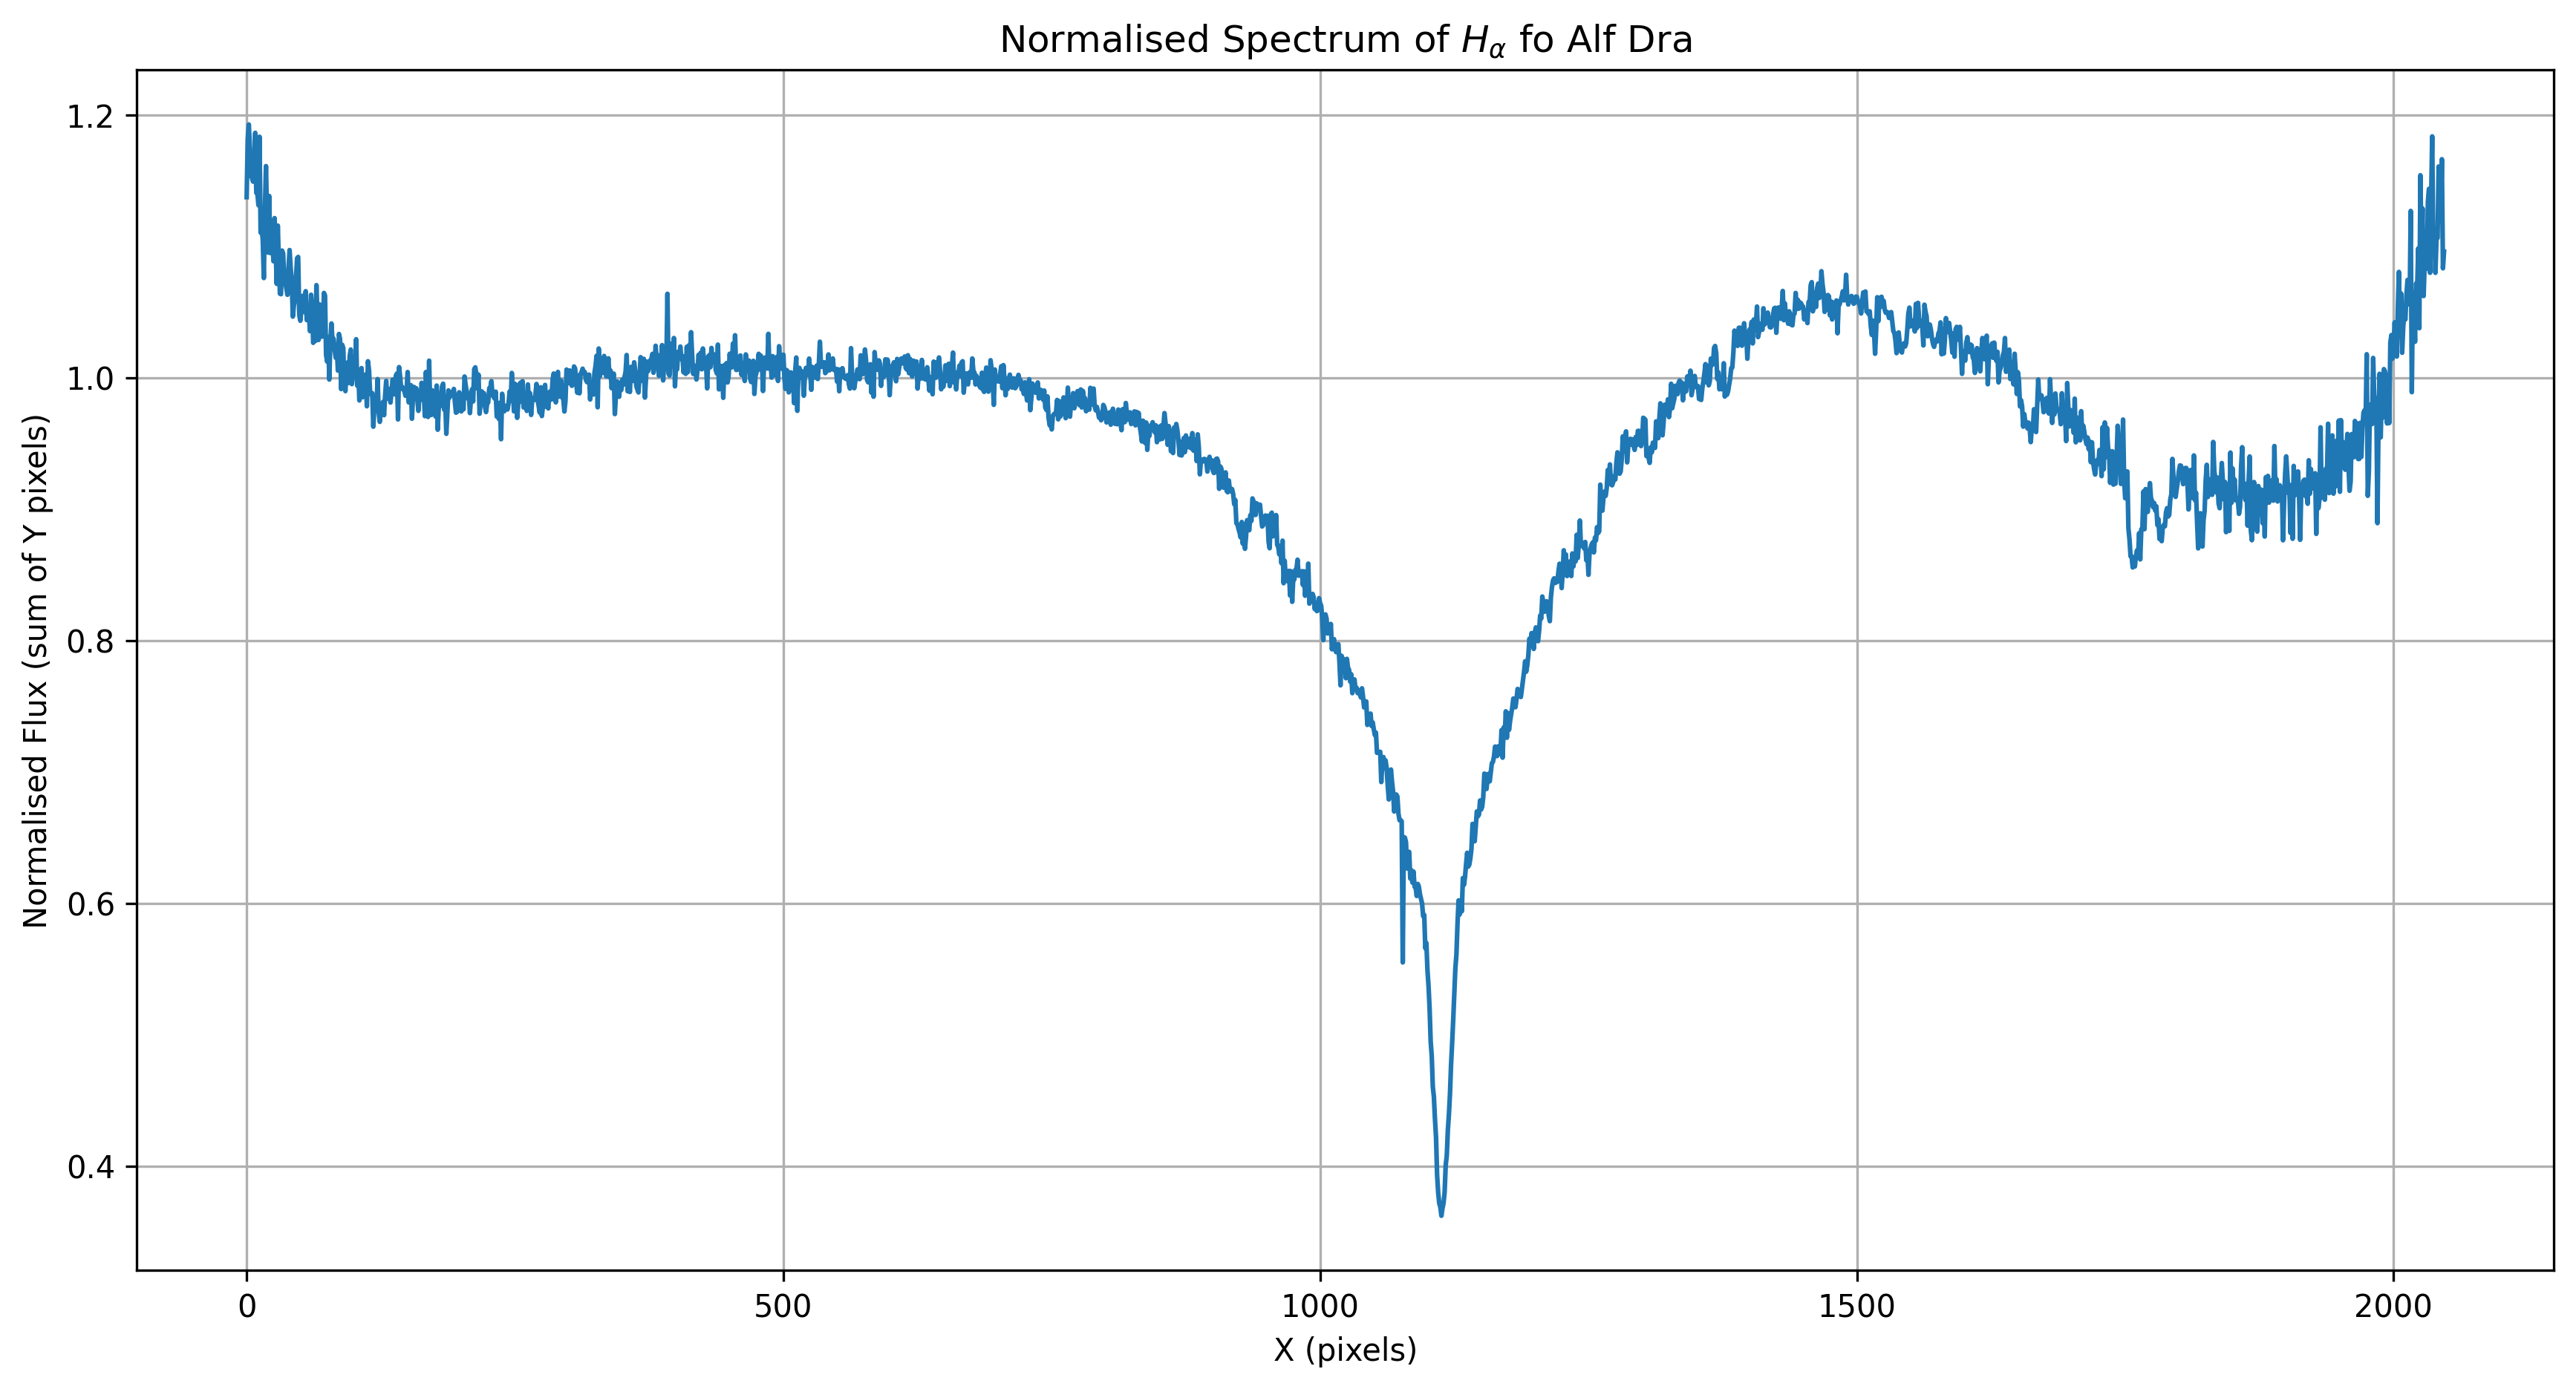

In [71]:
plt.figure(figsize=(14,7),dpi=300)
plt.title(r'Normalised Spectrum of $H_\alpha$ fo Alf Dra')
plt.grid()
plt.xlabel('X (pixels)')
plt.ylabel('Normalised Flux (sum of Y pixels)')
plt.plot(continium_normarlised)


## Finding Amplitude and Position

<div class="alert alert-success">

  **Fitting a Lorentzian**
 
1. Full Set

2. specific Range

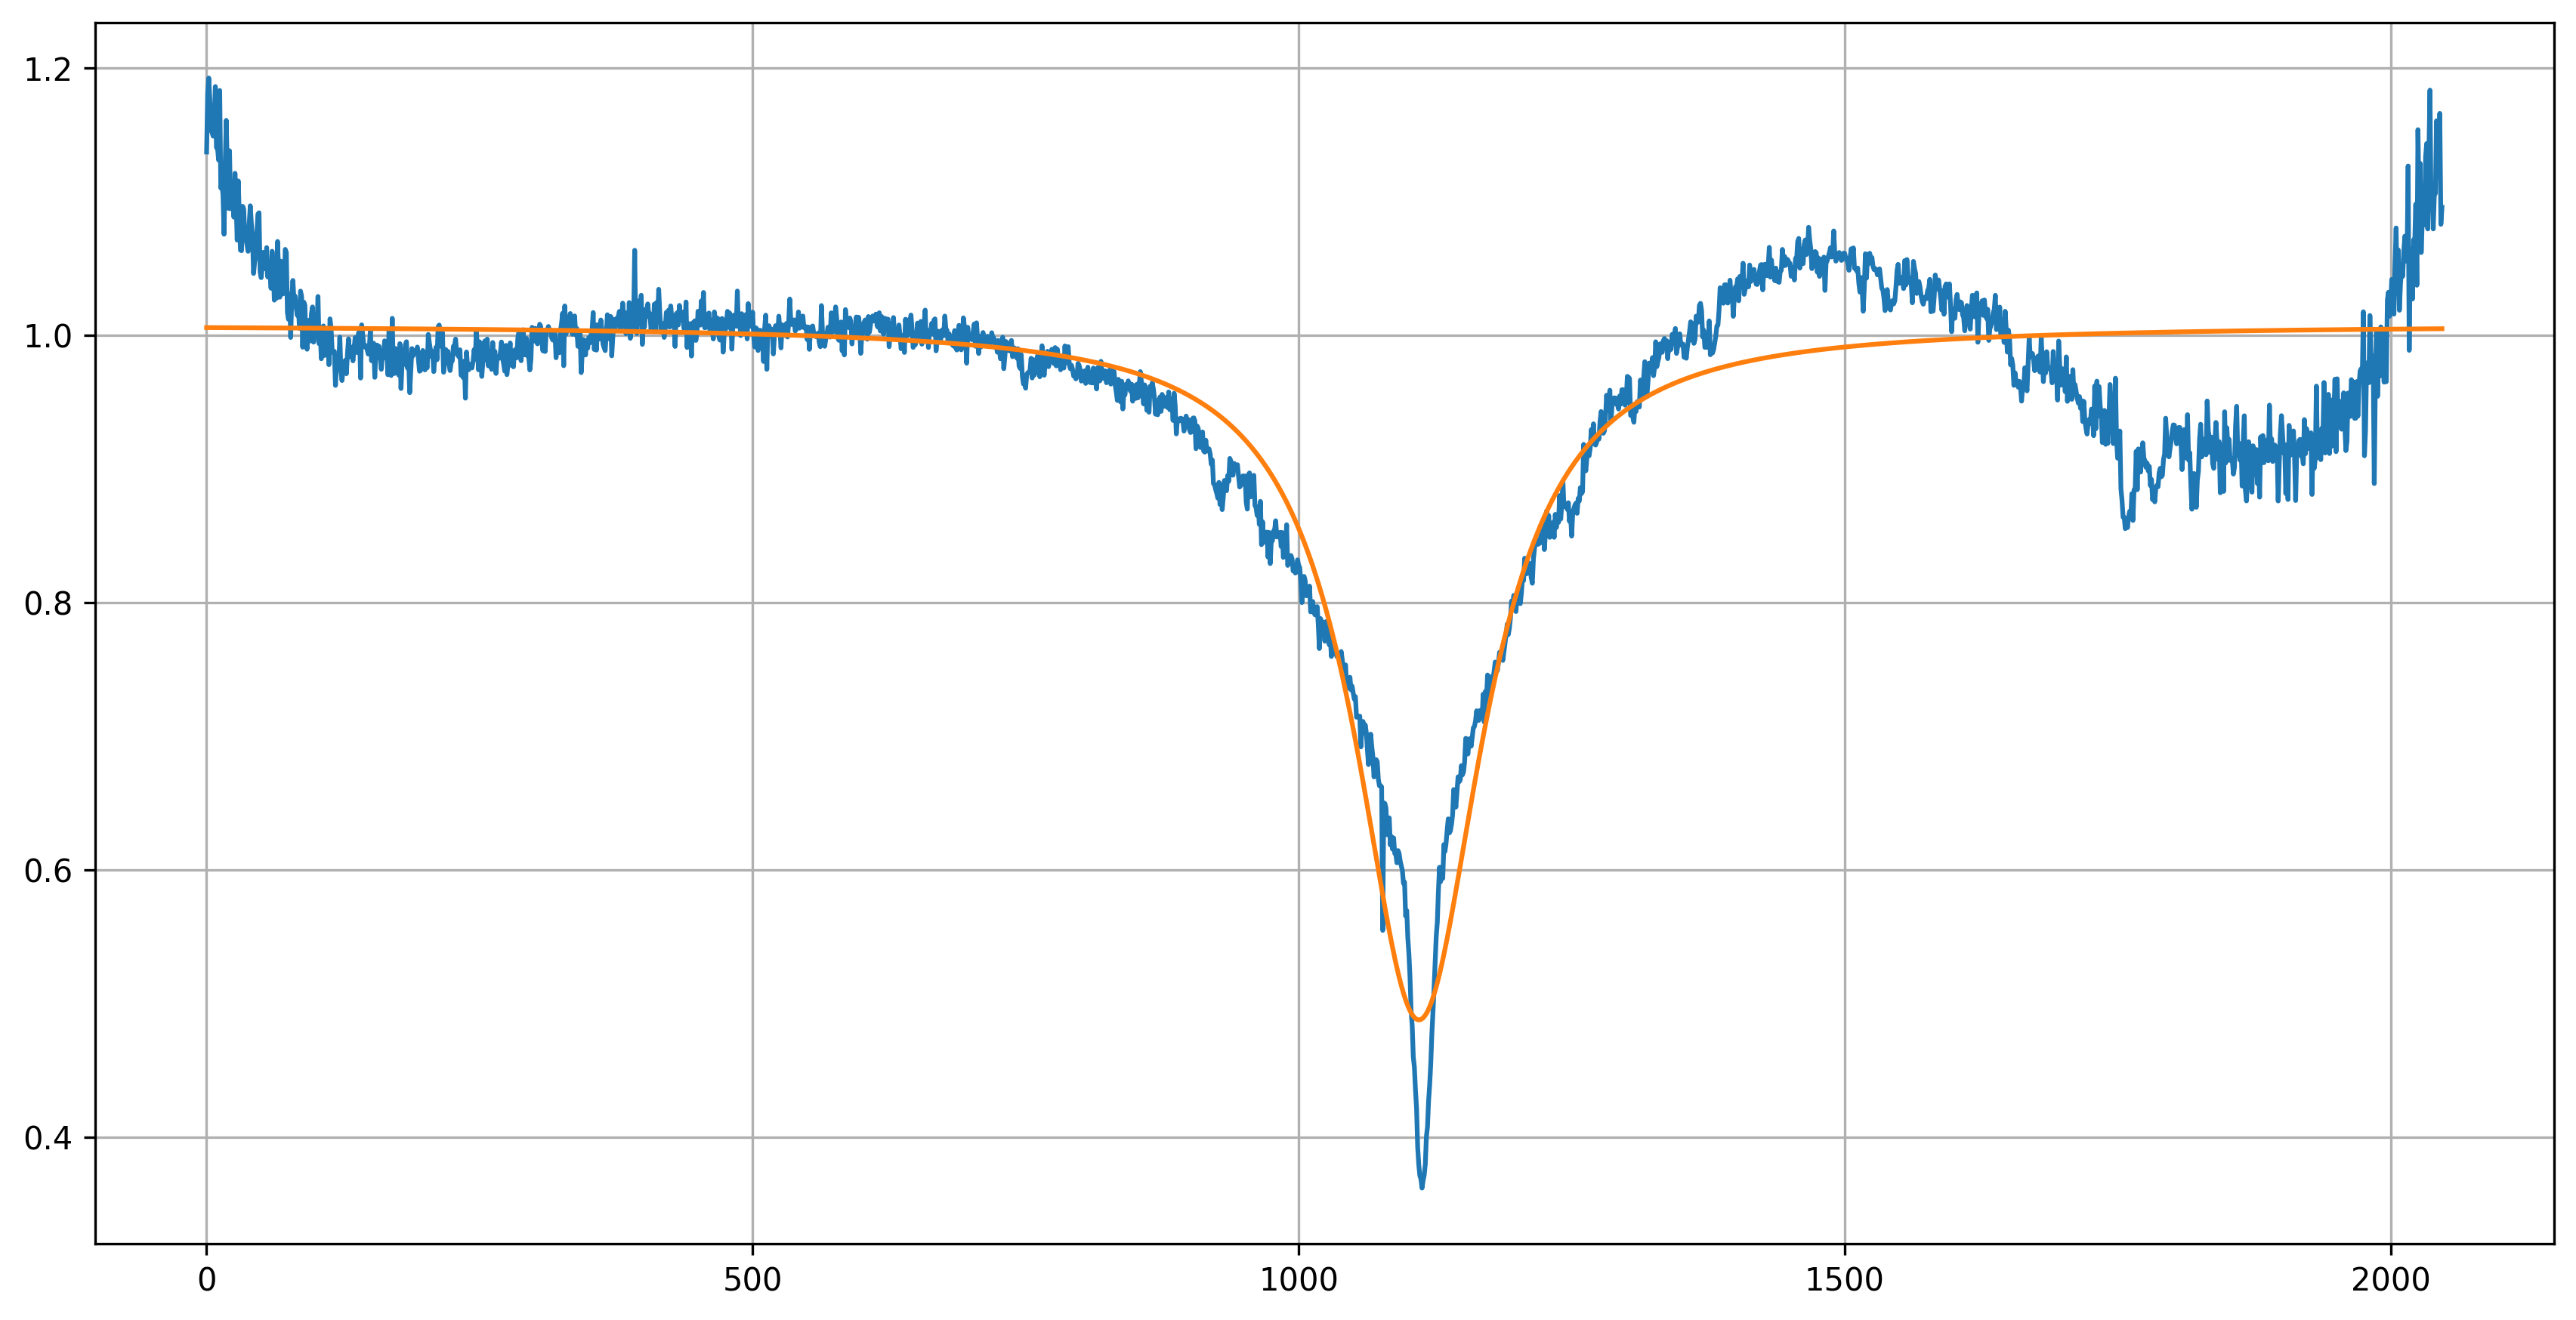

In [72]:
line_par, line_cov = optimize.curve_fit(ha.Lorentz, np.arange(0, len(continium_normarlised)), continium_normarlised, p0=[-1,-3,1000,5], sigma=normalised_err)
size = np.size(continium_normarlised)
xValues = np.linspace(0, size, size)
line_shape = ha.Lorentz(xValues,line_par[0],line_par[1],line_par[2],line_par[3])

plt.figure(figsize=(14,7), dpi=300)
plt.grid()
plt.plot(continium_normarlised)
plt.plot(line_shape)

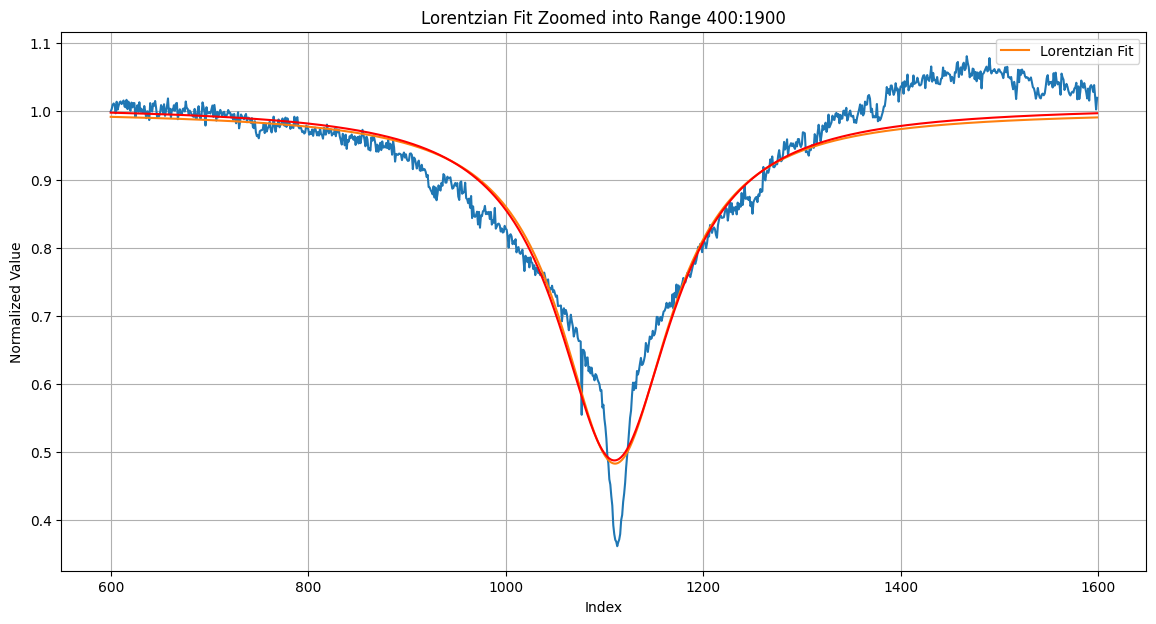

In [73]:

# Define the range you want to fit (400 to 1900)
start, end = 600, 1600

# Slice the data to the desired range
data_slice = continium_normarlised[start:end]
x_slice = np.arange(start, end)

# Fit the Lorentzian to the sliced data
line_par, line_cov = optimize.curve_fit(
    ha.Lorentz,
    x_slice,  # Use only the sliced x values
    data_slice,  # Use only the sliced data
    p0=[-1, -3, 1000, 5],  # Initial guess
    sigma=normalised_err[start:end]  # Sigma for weighting during fit
)

# Generate the Lorentzian fit for the same x values in the sliced range
line_shape_1 = ha.Lorentz(x_slice, line_par[0], line_par[1], line_par[2], line_par[3])

# Plot the data and the fitted Lorentzian
plt.figure(figsize=(14, 7))
plt.grid()
plt.plot(x_slice, data_slice)
plt.plot(x_slice, line_shape_1, label="Lorentzian Fit")
plt.plot(x_slice,line_shape[start:end],'r')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Lorentzian Fit Zoomed into Range 400:1900')
plt.show()


<div class="alert alert-success">

  **Finding best fit using chi2**

1. Shift to the right
2. Shift to the left
3. Increasing the range
4. Decreasing the range


In [74]:
# Initialize lists to store results
H_alpha = []
H_err = []
chi2_left = []
chi2_right = []
chi2_increase = []
chi2_decrease = []


# Ensure x values are properly initialized
x = np.arange(0, len(continium_normarlised))

# First loop: shifting range leftward
for i in range(500):
    # Select data range
    mask = (x > 600 - i) & (x < 1600 - i)
    sample_nw = continium_normarlised[mask]
    x_range = x[mask]
    sigma_range = normalised_err[mask]

    # Initial guess for Lorentzian parameters: [Amplitude, Peak Position, Width, Offset]
    initial_guess = [-1, -3, 1000, 5]

    # Fit Lorentzian curve
    try:
        popt, pcov = optimize.curve_fit(ha.Lorentz, x_range, sample_nw, p0=initial_guess, maxfev=10000, sigma=sigma_range)
        line_shape = ha.Lorentz(x, *popt)  # Fix: use `x_range` instead of undefined `x_slice`

        # Extract fitted parameters
        l0, l1, l2, l3 = popt

        # Store results
        H_alpha.append(l1)
        H_err.append(np.sqrt(np.diag(pcov))[1])
        chi2_left.append(ha.chi2_red(ha.residuals(continium_normarlised, line_shape), 4, normalised_err))

    except RuntimeError:
        print(f"Fit failed at iteration {i}")

# Second loop: shifting range rightward
for i in range(500):
    # Select data range
    mask = (x > (600 + i)) & (x < (1600 + i))
    sample_nw = continium_normarlised[mask]
    x_range = x[mask]
    sigma_range = normalised_err[mask]

    # Initial guess for Lorentzian parameters
    initial_guess = [-1, -3, 1000, 5]

    # Fit Lorentzian curve
    try:
        popt, pcov = optimize.curve_fit(ha.Lorentz, x_range, sample_nw, p0=initial_guess, maxfev=10000, sigma=sigma_range)
        line_shaped = ha.Lorentz(x, *popt)  # Fix: use `x_range` instead of undefined `x_slice`

        # Extract fitted parameters
        l0, l1, l2, l3 = popt

        # Store results
        H_alpha.append(l1)
        H_err.append(np.sqrt(np.diag(pcov))[1])
        chi2_right.append(ha.chi2_red(ha.residuals(continium_normarlised, line_shaped), 4, normalised_err))

    except RuntimeError:
        print(f"Fit failed at iteration {i}")

# First loop: increasing the range
for i in range(len(continium_normarlised)):
    # Select data range
    mask = (x > 600 - i) & (x < 1600 + i)
    sample_nw = continium_normarlised[mask]
    x_range = x[mask]
    sigma_range = normalised_err[mask]

    # Initial guess for Lorentzian parameters: [Amplitude, Peak Position, Width, Offset]
    initial_guess = [-1, -3, 1000, 5]

    # Fit Lorentzian curve
    try:
        popt, pcov = optimize.curve_fit(ha.Lorentz, x_range, sample_nw, p0=initial_guess, maxfev=10000, sigma=sigma_range)
        line_shaped = ha.Lorentz(x, *popt)  # Fix: use `x_range` instead of undefined `x_slice`

        # Extract fitted parameters
        l0, l1, l2, l3 = popt

        # Store results
        H_alpha.append(l1)
        H_err.append(np.sqrt(np.diag(pcov))[1])
        chi2_increase.append(ha.chi2_red(ha.residuals(continium_normarlised, line_shaped), 4, normalised_err))

    except RuntimeError:
        print(f"Fit failed at iteration {i}")

# Second loop: decreasing the range
for i in range(400):
    # Select data range
    mask = (x > (600 + i)) & (x < (1600 - i))
    sample_nw = continium_normarlised[mask]
    x_range = x[mask]
    sigma_range = normalised_err[mask]

    # Initial guess for Lorentzian parameters
    initial_guess = [-1, -3, 1000, 5]

    # Fit Lorentzian curve
    try:
        popt, pcov = optimize.curve_fit(ha.Lorentz, x_range, sample_nw, p0=initial_guess, maxfev=10000, sigma=sigma_range)
        line_shaped = ha.Lorentz(x, *popt)  # Fix: use `x_range` instead of undefined `x_slice`

        # Extract fitted parameters
        l0, l1, l2, l3 = popt

        # Store results
        H_alpha.append(l1)
        H_err.append(np.sqrt(np.diag(pcov))[1])
        chi2_decrease.append(ha.chi2_red(ha.residuals(continium_normarlised, line_shaped), 4, normalised_err))

    except RuntimeError:
        print(f"Fit failed at iteration {i}")


In [75]:
chi2_min=[min(chi2_increase),min(chi2_decrease), min(chi2_left),min(chi2_right)]
chi2_min

[11.145423538484467, 11.53208432690121, 11.145479932883818, 11.53208432690121]

In [76]:
min(chi2_min)

11.145423538484467

<div class="alert alert-success">

  **Plot of best fit and parameters correction**

In [77]:
mask = (x > 600 - np.where(np.array(chi2_increase)==np.min(chi2_min))[0][0]) & ( x < 1600 + np.where(np.array(chi2_increase)==np.min(chi2_min))[0][0])
sample_nw = continium_normarlised[mask]
x_range = x[mask]
sigma_range = normalised_err[mask]

# Initial guess for Lorentzian parameters: [Amplitude, Peak Position, Width, Offset]
initial_guess = [-1, -3, 1000, 5]


popt, pcov = optimize.curve_fit(ha.Lorentz, x_range, sample_nw, p0=initial_guess, maxfev=10000, sigma=sigma_range)
line_shape_final = ha.Lorentz(x_range, *popt)  # Fix: use `x_range` instead of undefined `x_slice`


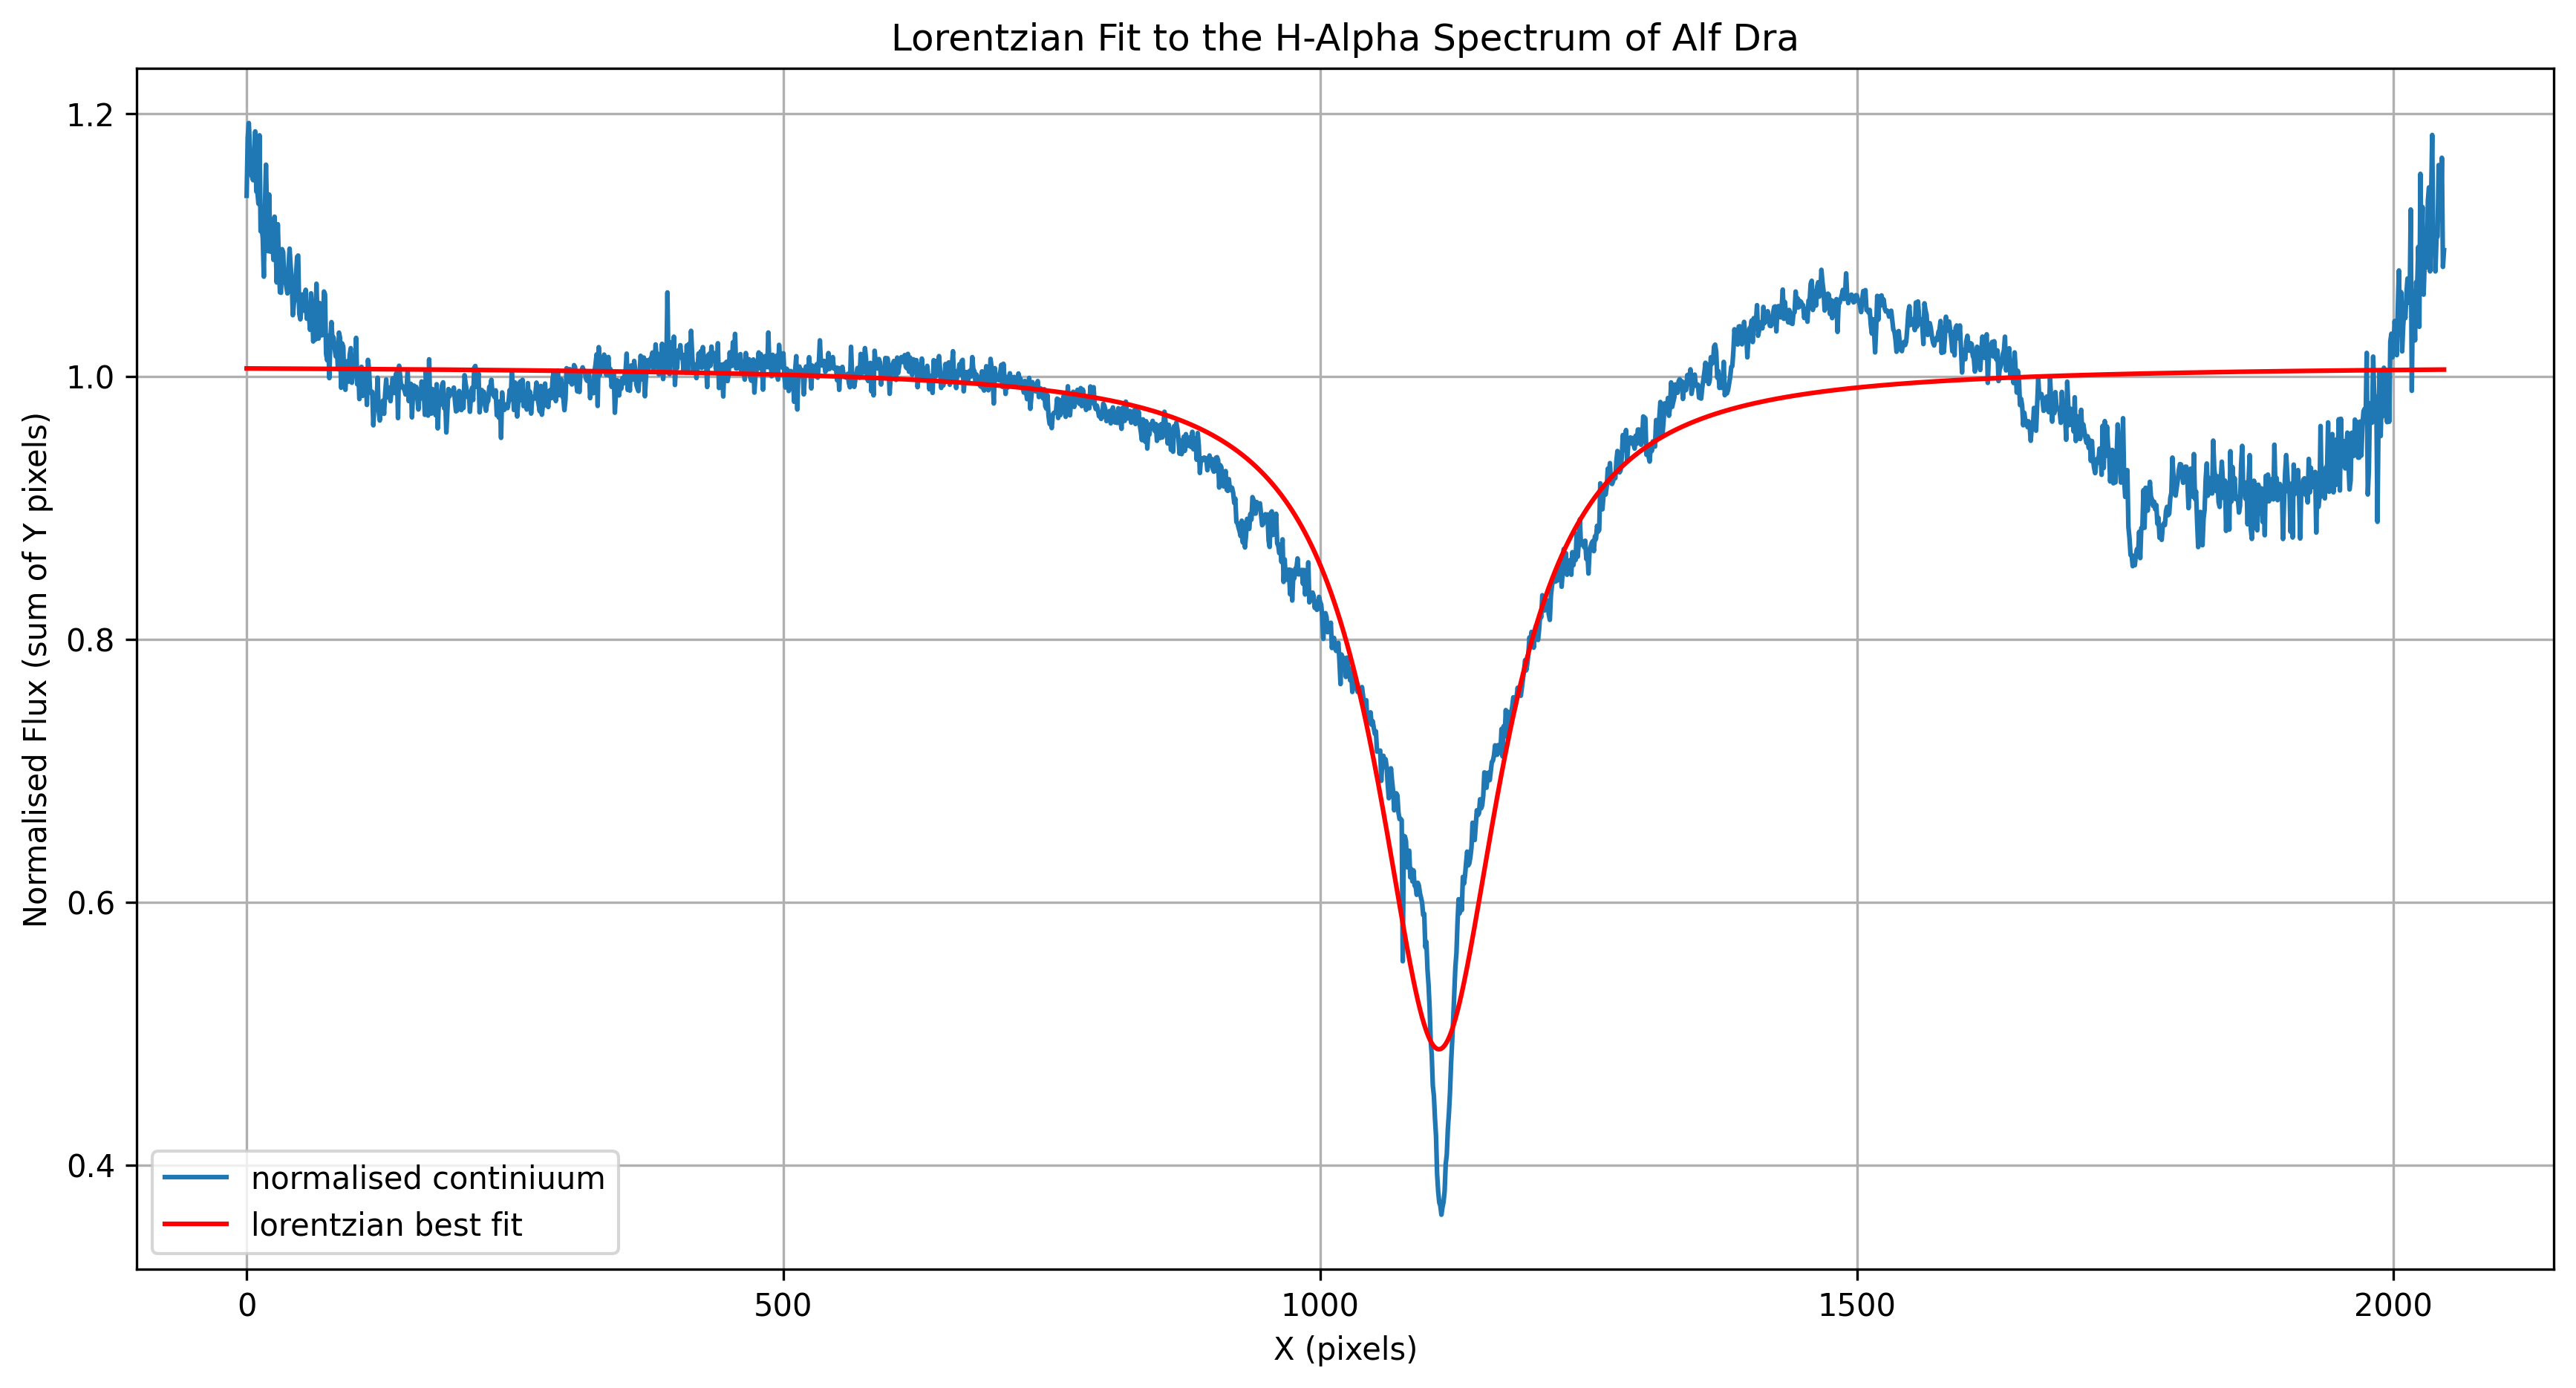

In [78]:


plt.figure(figsize=(14,7),dpi=300)
plt.title('Lorentzian Fit to the H-Alpha Spectrum of Alf Dra')

plt.plot(x_range, sample_nw, label= 'normalised continiuum')

plt.plot(x_range,line_shape_final,'r', label='lorentzian best fit')

plt.grid()
plt.legend()
plt.xlabel('X (pixels)')
plt.ylabel('Normalised Flux (sum of Y pixels)')
plt.show()

In [79]:
amplitude, position= popt[1],popt[2]

In [80]:
amplitude_err,position_err= ha.compute_param_uncertainty(1, 50,0.0001, x_range, sample_nw, sigma_range, popt),ha.compute_param_uncertainty(2, 50,0.001, x_range, sample_nw, sigma_range, popt)

In [81]:
print(f"amplitude ={amplitude:.3f} +- {amplitude_err:.3f}")
print(f"position ={position:.1f} +- {position_err:.1f}")

amplitude =-0.520 +- 0.049
position =1110.7 +- 10.7


## Finding S/N 

In [82]:
print(f"The Signal to Noise ratio of this image is {np.abs(amplitude/amplitude_err)}")

The Signal to Noise ratio of this image is 10.548833171387647
